In [45]:
from collections import Counter
import io
from pathlib import Path

from autogluon.text import TextPredictor
import fasttext.util
from gensim.test.utils import datapath
from gensim.models.fasttext import load_facebook_vectors
from matplotlib import pyplot as plt
import numpy as np
import lightgbm as lgb
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
import spacy
from tqdm import tqdm

from jjuoda_dl4.utils import BASE_DATA_DIR, BASE_MODEL_DIR

In [4]:
df_merged = pd.read_csv(BASE_DATA_DIR / "final" / "merged.csv")
df_merged.head()

,title,text,subject,date,is_fake,num_words_text,num_words_title
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",False,746,10
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",False,621,9
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",False,454,10
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",False,372,9
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",False,849,11


In [5]:
# drop rows where both text and title were cleaned to empty string
df_merged = df_merged[~(df_merged.title.isna() & df_merged.text.isna())]

# fill in nan values with empty string
df_merged.title.fillna("", inplace=True)
df_merged.text.fillna("", inplace=True)

### Baseline heuristic

#### Words in all caps

In [6]:
def count_all_caps(texts: pd.Series):
    return texts.str.count(r"\b[A-Z]{2,}\b")


def get_caps_table(texts: pd.Series, is_fake: pd.Series):
    num_words = texts.str.split().str.len().values
    num_caps = count_all_caps(texts).values

    is_fake = is_fake[num_words > 0]
    num_caps = num_caps[num_words > 0]
    num_words = num_words[num_words > 0]

    cap_frequency = num_caps / num_words

    mean_caps_true = cap_frequency[~is_fake].mean()
    mean_caps_fake = cap_frequency[is_fake].mean()

    return mean_caps_true, mean_caps_fake


mean_caps_title_true, mean_caps_title_fake = get_caps_table(
    df_merged.title, df_merged.is_fake
)
mean_caps_text_true, mean_caps_text_fake = get_caps_table(
    df_merged.text, df_merged.is_fake
)


def _get_caps_odds(texts, mean_true, mean_fake):
    num_caps = count_all_caps(texts).values
    num_words = texts.str.split().str.len().values
    cap_frequency = num_caps / num_words
    text_odds = np.ones((len(cap_frequency), 2))
    text_odds[cap_frequency < mean_true] = np.array([[4, 1]])
    text_odds[cap_frequency > mean_fake] = np.array([[1, 4]])

    mask = np.logical_and(cap_frequency >= mean_true, cap_frequency <= mean_fake)
    dist_true = cap_frequency - mean_true
    dist_fake = cap_frequency - mean_fake

    text_odds[mask & (dist_true < dist_fake)] = np.array([[2, 3]])
    text_odds[mask & (dist_true > dist_fake)] = np.array([[3, 2]])
    return text_odds


def get_caps_odds(df: pd.DataFrame):
    text_odds = _get_caps_odds(df.text, mean_caps_title_true, mean_caps_title_fake) / 2
    text_odds[text_odds < 1] = 1  # reduce difference between fake and true
    title_odds = _get_caps_odds(df.title, mean_caps_title_true, mean_caps_title_fake)

    return text_odds * title_odds

In [7]:
sample = df_merged.sample(10)
sample[["true_odds", "fake_odds"]] = get_caps_odds(sample)
with pd.option_context("display.max_colwidth", 120, "expand_frame_repr", False):
    print(sample[["title", "is_fake", "true_odds", "fake_odds"]])

                                                                                                                         title  is_fake  true_odds  fake_odds
23039                                Trump Just Got WRECKED By Chelsea Clinton Over His Dumbass Slavery Remarks (TWEETS/VIDEO)     True        2.0        4.0
34854                                                    BREAKING: DNC CHARWOMAN Shouted Down In Chaos During Opening Remarks      True        1.5        4.0
8574                                                               House Speaker Ryan: Khan family sacrifice should be honored    False        8.0        1.0
37525                                        TUCKER ON COMEY’S FIRING: “Dictatorship by the unelected…that’s the REAL danger”      True        1.5        4.0
41413  WHY IS THE MEDIA HIDING This Endorsement?…KKK Klan Leader On Hillary: “She’s A Democrat, The Klan Has ALWAYS Been A ...     True        2.0        4.0
10367                                               

In [8]:
eval = df_merged.copy()
eval[["true_odds", "fake_odds"]] = get_caps_odds(eval)
((eval.true_odds < eval.fake_odds) == eval.is_fake).mean()

/tmp/ipykernel_234884/335387911.py:32: RuntimeWarning: invalid value encountered in true_divide
  cap_frequency = num_caps / num_words


0.6817705896767582

In [9]:
get_caps_odds(df_merged.loc[[30540]])

array([[1.5, 4. ]])

#### Keyword search

In [10]:
# nlp = spacy.load("en_core_web_sm")

In [11]:
def extract_keywords(texts: pd.Series, mask):
    keywords = Counter()
    for doc in nlp.pipe(df_merged.text[mask].str.lower(), batch_size=100):
        keywords.update(str(s).lower() for s in doc.ents)

    return (
        pd.DataFrame(keywords.items(), columns=["keyword", "count"])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

In [12]:
# fake_keywords = extract_keywords(df_merged.text, df_merged.is_fake)
# fake_keywords.head()

In [13]:
# fake_keywords_title = extract_keywords(df_merged.title, df_merged.is_fake)
# fake_keywords_title.head()

In [14]:
# true_keywords = extract_keywords(df_merged.text, ~df_merged.is_fake)
# true_keywords.head()

In [15]:
# true_keywords_title = extract_keywords(df_merged.title, ~df_merged.is_fake)
# true_keywords_title.head()

In [16]:
# set(fake_keywords.head(100).keyword) - set(true_keywords.head(200).keyword)

In [17]:
# set(fake_keywords_title.head(100).keyword) - set(true_keywords_title.head(200).keyword)

Hm, maybe:  
- cia makes sense to appear more in conspiracy theories/fake news.
- islam knowing that most of fake news come from American right
- Hillary Clinton is likely mentioned by both a lot, since the period is 2015-2017, but Bill Clinton is a surprise

In [18]:
# set(true_keywords.head(100).keyword) - set(fake_keywords.head(200).keyword)

In [19]:
# set(true_keywords.head(100).keyword) - set(fake_keywords.head(200).keyword)

Much more international news. In this dataset fake news are about US politics.

In [20]:
true_keywords_set = {
    "beijing",
    "britain",
    "eu",
    "japan",
    "myanmar",
    "north korean",
    "puerto rico",
    "south korea",
    "taiwan",
    "the european union",
    "the united nations",
    "turkish",
    "u.n.",
}
fake_keywords_set = set(["conspiracy", "cia", "islam", "bill clinton", "video", "lol", "wow"])


def contains_keywords(text: str, keywords: set):
    return sum(s.lower() in keywords for s in text.split())


def _get_keyword_odds(texts: pd.Series):
    true_keywords_count = texts.apply(
        lambda x: contains_keywords(x, true_keywords_set)
    ).values.reshape(-1, 1)
    fake_keywords_count = texts.apply(
        lambda x: contains_keywords(x, fake_keywords_set)
    ).values.reshape(-1, 1)
    return np.concatenate([true_keywords_count + 1, fake_keywords_count + 1], axis=1)


def get_keyword_odds(df: pd.DataFrame):
    text_odds = _get_keyword_odds(df.text)
    title_odds = _get_keyword_odds(df.title)
    return text_odds * title_odds

In [21]:
sample = df_merged.sample(10)
sample[["true_odds", "fake_odds"]] = get_keyword_odds(sample)
with pd.option_context("display.max_colwidth", 120, "expand_frame_repr", False):
    print(sample[["title", "is_fake", "true_odds", "fake_odds"]])

                                                                                                                         title  is_fake  true_odds  fake_odds
34264  ILLEGAL ALIEN Who Helps Illegals Stay In U.S. ARRESTED For Drunk Driving…Why The Left May Not Be Able To Stop Her De...     True          1          1
15527                                                                              Pakistan debates how to fill education gaps    False          1          1
33298         BRAVO! TRUMP’S INAUGURAL BISHOP SPEAKS OUT: “I’ve been called a sellout” BUT “We’re supposed to love everyone!”      True          1          1
30588                      ATLANTA: PANDEMONIUM As World’s Largest Airport Goes DARK…Airport Evacuated…1,161 Flights Canceled      True          1          1
34513                                    HILLARY IS FURIOUS OVER EMAIL HACKS…Openly Threatens War With Russia…Media Is SILENT      True          1          1
2040                                                

#### All odds together

In [22]:
def get_odds(df: pd.DataFrame):
    odd_funcs = [get_caps_odds, get_keyword_odds]
    odds = np.ones((len(df), 2))
    for func in odd_funcs:
        odds *= func(df)
    return odds

def predict_proba(df: pd.DataFrame):
    odds = get_odds(df)
    return odds / odds.sum(axis=1, keepdims=True)


def predict(df: pd.DataFrame):
    return predict_proba(df).argmax(axis=1)

In [23]:
eval = df_merged.copy()
eval[["true_odds", "fake_odds"]] = get_odds(eval)
((eval.true_odds < eval.fake_odds) == eval.is_fake).mean()

/tmp/ipykernel_234884/335387911.py:32: RuntimeWarning: invalid value encountered in true_divide
  cap_frequency = num_caps / num_words


0.6911270021608857

Ok, keyword extraction was work and didn't help much.

### Classical models

In [24]:
pretrained_fasttext = fasttext.load_model(str(BASE_MODEL_DIR / 'cc.en.300.bin'))

In [25]:
encodings = np.array([pretrained_fasttext.get_sentence_vector(s.lower()) for s in df_merged.text])

In [26]:
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000)
logistic_regression.fit(encodings, df_merged.is_fake)

LogisticRegression(max_iter=1000)

In [27]:
(logistic_regression.predict(encodings) == df_merged.is_fake).mean()

0.9374902537369957

Dataset is horrendous. Distinguishing real news from fake news could be pretty hard, but in this case real news only comes from Reuters and fake news come from random sources, mostly twitter. They are very different and even after cleaning up dataset a bit, simple logistic regression achieves 94.7% accuracy without any feature engineering.

#### Evaluation against nela-gt-2018

In [28]:
nela_gt_2018_articles_df = pd.read_csv(
    BASE_DATA_DIR / "interim" / "nela-gt-2018-articles.csv", index_col=0
)
nela_gt_2018_articles_df.head()

,path,title,date,source,source_score
0,/home/julius/lp/Turing/jjuoda-DL.4/data/raw/NE...,Dozens of manufacturing companies testified ab...,2018-09-08,Business Insider,2.0
1,/home/julius/lp/Turing/jjuoda-DL.4/data/raw/NE...,Pentagon routinely briefs Trump on military op...,2018-09-08,RT,0.0
2,/home/julius/lp/Turing/jjuoda-DL.4/data/raw/NE...,US Air Force determining facts appropriate pro...,2018-09-08,RT,0.0
3,/home/julius/lp/Turing/jjuoda-DL.4/data/raw/NE...,Pentagon designing Glide Breaker interceptor t...,2018-09-08,RT,0.0
4,/home/julius/lp/Turing/jjuoda-DL.4/data/raw/NE...,Developing nation US cant afford to subsidize ...,2018-09-08,RT,0.0


In [29]:
nela_gt_2018_articles_df["is_fake"] = np.nan

In [30]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def batched_preprocessing(articles_df: pd.DataFrame, ft_encoder, batch_size: int=128):
    for batch_indices in tqdm(chunks(articles_df.index, batch_size)):
        text_encodings = []
        for article_path in articles_df.loc[batch_indices].path:
            with open(article_path, "r") as f:
                text = f.read().replace("\n", " ")
            text_encodings.append(ft_encoder.get_sentence_vector(text.lower()))
        text_encodings = np.array(text_encodings)
        title_encodings = np.array([ft_encoder.get_sentence_vector(s.lower()) for s in articles_df.loc[batch_indices].title])
        encodings = np.concatenate([text_encodings, title_encodings], axis=1)
        yield encodings, articles_df.loc[batch_indices].is_fake

def batched_predictions(articles: pd.DataFrame, ft_encoder, model, batch_size=128):
    for text_encodings, _ in batched_preprocessing(articles, ft_encoder, batch_size):
        preds = model.predict_proba(text_encodings)
        yield preds

def batched_training(articles_df: pd.DataFrame, ft_encoder, model, batch_size=128):
    for text_encodings, is_fake in batched_preprocessing(articles_df, ft_encoder, batch_size):
        sample_weight = np.ones(len(is_fake))
        num_fake = is_fake.sum()
        sample_weight[is_fake.astype(bool)] = (len(is_fake) - num_fake) / num_fake
        model.partial_fit(text_encodings, is_fake, sample_weight=sample_weight, classes=[0, 1])

In [31]:
# predicted_probas = np.concatenate(list(batched_predictions(nela_gt_2018_articles_df, pretrained_fasttext, logistic_regression)))

In [32]:
# ax = sns.boxplot(x=nela_gt_2018_articles_df.source_score, y=predicted_probas[:, 0])

# ax.set_ylabel("Probability of being fake")

# plt.savefig(BASE_DATA_DIR / "processed" / "nela-gt-2018-articles-probability-of-being-fake.png")

I am not sure I assigned scores to sources correctly, however, I'm pretty sure that as we increase source score, proportion of reliable news increases. As I feared, model trained on the original dataset generalizes poorly. Let's train our model on articles I'm most confident about.

In [33]:
nela_gt_2018_scores_df = pd.read_csv(BASE_DATA_DIR / "interim" / "nela-gt-2018-scores.csv")
nela_gt_2018_scores_df.head()

,source,score
0,21stCenturyWire,1.0
1,ABC News,2.5
2,AMERICAblog News,0.0
3,Activist Post,1.0
4,Addicting Info,1.0


In [34]:
reliable_sources = nela_gt_2018_scores_df[nela_gt_2018_scores_df.score > 2]
unreliable_sources = nela_gt_2018_scores_df[nela_gt_2018_scores_df.score <= -2]

reliable_sources

,source,score
1,ABC News,2.5
8,BBC,2.5
16,CBS News,2.5
18,CNN,2.5
81,NPR,2.5
82,National Review,2.5
86,New Yorker,2.5
94,PBS,2.5
146,The Guardian,2.5
149,The Huffington Post,2.5


In [35]:
unreliable_sources

,source,score
11,Bipartisan Report,-2.0
13,Breitbart,-3.0
31,Daily Mail,-2.0
96,Pamela Geller Report,-2.0
145,The Gateway Pundit,-2.0


In [36]:
val_unreliable_source = unreliable_sources.iloc[0]
train_unreliable_sources = unreliable_sources.iloc[1:]

val_reliable_source = reliable_sources.iloc[0]
train_reliable_sources = reliable_sources.iloc[1:]

In [37]:
print(f"Num articles in val unreliable source: {sum(nela_gt_2018_articles_df.source == val_unreliable_source.source)}")
print(f"Num articles in val reliable source: {sum(nela_gt_2018_articles_df.source == val_reliable_source.source)}")

Num articles in val unreliable source: 4060
Num articles in val reliable source: 2808


In [38]:
model = SGDClassifier(loss="log")
# model.partial_fit(encodings, df_merged.is_fake, classes=[0, 1])

In [39]:
train_sources = pd.concat([train_reliable_sources, train_unreliable_sources])
train_articles_df = nela_gt_2018_articles_df[nela_gt_2018_articles_df.source.isin(train_sources.source)].copy()
train_articles_df["is_fake"] = train_articles_df.source_score < 0
train_articles_df = train_articles_df.sample(frac=1)  # shuffle

,path,title,date,source,source_score,is_fake
379178,/home/julius/lp/Turing/jjuoda-DL.4/data/raw/NE...,What does Jeremy Hunt want from the United States,2018-08-22,BBC,2.5,False
286178,/home/julius/lp/Turing/jjuoda-DL.4/data/raw/NE...,What Its Like to Talk with North Korea,2018-04-27,National Review,2.5,False
54714,/home/julius/lp/Turing/jjuoda-DL.4/data/raw/NE...,Donald Trumps Weird Oval Office Pose Sparks Hi...,2018-08-31,The Huffington Post,2.5,False
88522,/home/julius/lp/Turing/jjuoda-DL.4/data/raw/NE...,Paul Manafortaposs trial a hit in the Virginia...,2018-08-10,USA Today,2.5,False
105001,/home/julius/lp/Turing/jjuoda-DL.4/data/raw/NE...,Kids These Days Unruly Goats Graze Hell Across...,2018-08-03,NPR,2.5,False


In [56]:
for index, article in train_articles_df.iterrows():
    with open(article.path, "r") as f:
        text = f.read().replace("\n", " ")
    train_articles_df.loc[index, "text"] = text

In [41]:
val_sources = pd.concat([val_reliable_source, val_unreliable_source])
val_articles_df = nela_gt_2018_articles_df[nela_gt_2018_articles_df.source.isin(val_sources.source)].copy()
val_articles_df["is_fake"] = (val_articles_df.source_score < 0).astype(int)

In [58]:
for index, article in val_articles_df.iterrows():
    with open(article.path, "r") as f:
        text = f.read().replace("\n", " ")
    val_articles_df.loc[index, "text"] = text

In [42]:
for epoch in range(5):
    batched_training(train_articles_df, pretrained_fasttext, model, batch_size=128)
    val_preds = np.concatenate(list(batched_predictions(val_articles_df, pretrained_fasttext, model, batch_size=128)))
    val_acc = ((val_preds[:, 0] > 0.5) == val_articles_df.is_fake).mean()
    print(f"Epoch {epoch} val accuracy: {val_acc}")

592it [01:02,  9.49it/s]
54it [00:09,  5.59it/s]


Epoch 0 val accuracy: 0.2925160163075131


592it [00:58, 10.15it/s]
54it [00:06,  8.24it/s]


Epoch 1 val accuracy: 0.3031450203843914


592it [00:57, 10.25it/s]
54it [00:06,  8.36it/s]


Epoch 2 val accuracy: 0.30023296447291786


592it [01:02,  9.40it/s]
54it [00:07,  7.37it/s]


Epoch 3 val accuracy: 0.3197437390797903


592it [00:58, 10.08it/s]
54it [00:06,  8.04it/s]

Epoch 4 val accuracy: 0.31887012230634826


In [43]:
visual_check = nela_gt_2018_articles_df.sample(n=1000)
predicted_probas = np.concatenate(list(batched_predictions(visual_check, pretrained_fasttext, model, batch_size=128)))

8it [00:03,  2.42it/s]


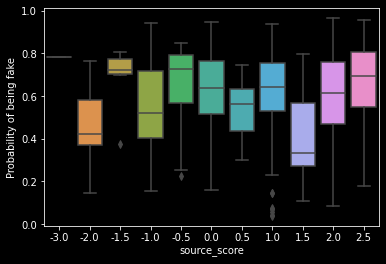

In [44]:
ax = sns.boxplot(x=visual_check.source_score, y=predicted_probas[:, 0])

ax.set_ylabel("Probability of being fake")

plt.savefig(BASE_DATA_DIR / "processed" / "trained_nela-gt-2018-articles-probability-of-being-fake.png")

Model does have potential to separate true stories from fake ones. At least it's performance on training set is not absolutely atrocious.

Now I have two ideas:
1. I'm representing whole article as 300 numbers. I could give my model more information
2. Data might not be linearly separable, I can try more complex model.

Solution 2. is simpler to code, so I'll go with it first.

#### LightGBM

In [74]:
train_encodings_text = np.stack([pretrained_fasttext.get_sentence_vector(article.text) for _, article in train_articles_df.iterrows()])
train_encodings_title = np.stack([pretrained_fasttext.get_sentence_vector(article.title) for _, article in train_articles_df.iterrows()])
train_encodings = np.concatenate([train_encodings_text, train_encodings_title], axis=1)

val_encodings_text = np.stack([pretrained_fasttext.get_sentence_vector(article.text) for _, article in val_articles_df.iterrows()])
val_encodings_title = np.stack([pretrained_fasttext.get_sentence_vector(article.title) for _, article in val_articles_df.iterrows()])
val_encodings = np.concatenate([val_encodings_text, val_encodings_title], axis=1)

In [76]:
train_weight = np.ones(len(train_articles_df.is_fake))
num_fake = train_articles_df.is_fake.sum()
train_weight[train_articles_df.is_fake.astype(bool)] = (len(train_articles_df) - num_fake) / num_fake

val_weight = np.ones(len(val_articles_df.is_fake))
num_fake = val_articles_df.is_fake.sum()
val_weight[val_articles_df.is_fake.astype(bool)] = (len(val_articles_df) - num_fake) / num_fake

In [77]:
train_dataset = lgb.Dataset(train_encodings, label=train_articles_df.is_fake, weight=train_weight)
val_dataset = lgb.Dataset(val_encodings, label=val_articles_df.is_fake, weight=val_weight)

In [126]:
param = {'num_leaves': 11, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 100
bst = lgb.train(param, train_dataset, num_round, valid_sets=[val_dataset])

[LightGBM] [Info] Number of positive: 11550, number of negative: 64175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.966651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153000
[LightGBM] [Info] Number of data points in the train set: 75725, number of used features: 600
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's auc: 0.73778
[2]	valid_0's auc: 0.785156
[3]	valid_0's auc: 0.811487
[4]	valid_0's auc: 0.809535
[5]	valid_0's auc: 0.825488
[6]	valid_0's auc: 0.832019
[7]	valid_0's auc: 0.846005
[8]	valid_0's auc: 0.853088
[9]	valid_0's auc: 0.852874
[10]	valid_0's auc: 0.859487
[11]	valid_0's auc: 0.858063
[12]	valid_0's auc: 0.865585
[13]	valid_0's auc: 0.865004
[14]	valid_0's auc: 0.868055
[15]	valid_0's auc: 0.869477
[16]	valid_0's auc: 0.867466
[17]	valid_0's auc: 0.869072
[18]	valid_0's auc:

In [127]:
preds = []

sample = nela_gt_2018_articles_df.dropna(subset=["title"]).sample(n=10000)

for enc, labels in batched_preprocessing(sample, pretrained_fasttext, batch_size=128):
    preds.append(bst.predict(enc))
preds = np.concatenate(preds)

79it [00:21,  3.74it/s]


Text(0.5, 0.98, 'Distribution of fake articles by source score')

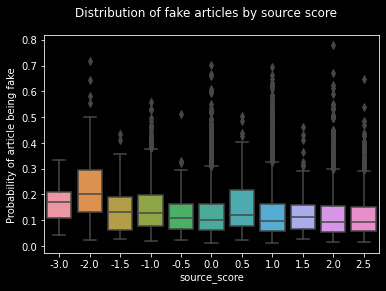

In [132]:
ax = sns.boxplot(x=sample.source_score, y=preds)
ax.set_ylabel("Probability of article being fake")

plt.suptitle("Distribution of fake articles by source score")

Ok, the trend looks as it should - decreasing probability of news being fake with source score increasing. That trend is very modest. I'll have to give more information to the model. Auc looks pretty good even on this little data.

#### Autogluon


In [129]:
ag_predictor = TextPredictor(label="is_fake", problem_type="binary", eval_metric="acc", path=BASE_MODEL_DIR / "AutoGluon")
ag_predictor.fit(train_articles_df[["text", "is_fake"]], val_articles_df[["text", "is_fake"]], time_limit=60)

Problem Type="binary"
Column Types:
   - "text": text
   - "is_fake": categorical



RuntimeError: No GPU is detected in the machine and we will not proceed to run TextPredictor because they will train too slowly with only CPU. You may try to set `ngpus_per_trial` to a number larger than 0 when calling `.fit()`. Also, you can set the environment variable "AUTOGLUON_TEXT_TRAIN_WITHOUT_GPU=1" to force the model to use CPU for training.